In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold 
from sklearn import cluster 
from sklearn import preprocessing 

### Load the dataset

In [2]:
df = pd.read_csv("./prepared_mushrooms_sample.csv")

df.head(1)

,Unnamed: 0,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,...,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
0,0,1,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0


##### Dropping irrelevant col

In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.head(1)

,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,...,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
0,1,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0


In [4]:
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (4000, 95)


## Rescale Data

#### Other than ring-number all data is either 0 or 1 (was orginally categorical), 
##### can convert ring-number into an interval between [0,1] using MinMaxScaler

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)


##### Using code from lab 3 - can visualise the cluster 

In [44]:
colors = np.array(['orange', 'blue', 'lime', 'yellow', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## K Means clustering 

#### K means clustering is an unsupervised machine learning algorithm, the goal of the algorithm is 
#### to find groups within the dataset, the algorithm works by assigning each data point to 
#### one of the k clusters 

##### Finding the optimal value for k using the Elbow technique 

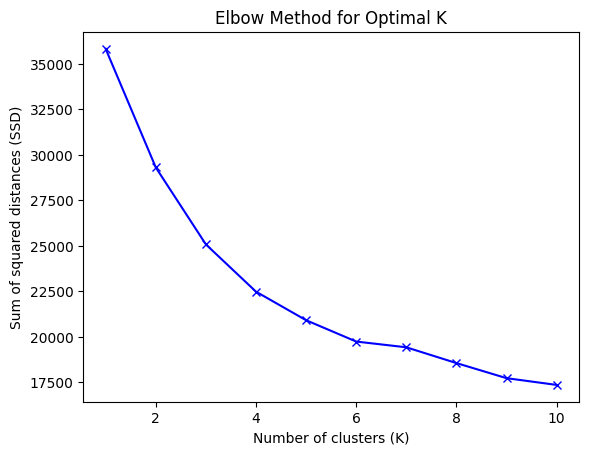

In [29]:
k_values = range(1, 11)

# Calculate SSD for each value of K
ssd = []
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k,n_init=10, random_state=0)
    kmeans.fit(data)
    ssd.append(kmeans.inertia_)

# Plot the SSD values for each K
plt.plot(k_values, ssd, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method for Optimal K')
plt.show()

##### the elbow method will run kmeans on the dataset for a range values, in this case 1 to 10
##### the plot is the mean distance, what we are lookinh for is the 'elbow point', where the
##### rate of decrease changes. In the plot above we see the curve drop significantly until we 
##### reach k=6, here the curver seems to level off 

### Using the silhouette technique to back up elbow technique 

In [33]:
from sklearn.metrics import silhouette_score

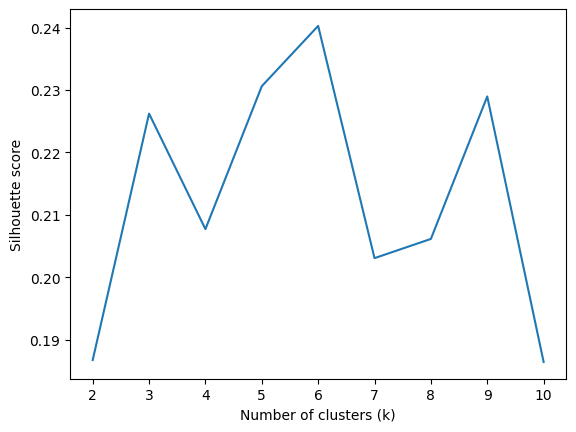

In [35]:
# Range of k values to test
k_values = range(2, 11)

# Initialize list to store silhouette scores
silhouette_scores = []

# Compute silhouette scores for each k
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, n_init=10,random_state=0)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, cluster_labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

##### the silhouette score / technique measures how similar a data point is within a cluster, compared
##### to other clusters, scikit learn provides a module that allows for the silhouette score to 
##### be calculated. we then plot a graph of these scores, the aim is to find the maximum silhoutte 
##### score. Looking at the graph is it clear that k=6 achived the max score 

### Both the elbow and silhouette have determined that the best value for k is 6

In [37]:
k = 6

In [38]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

## Applying multi-dimensional scaling (MDS) to project the data and
## K means clusters to a 2D space

In [39]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

In [40]:
XYcoordinates = manifold.MDS(n_components=2,normalized_stress=False).fit_transform(data_and_centers)

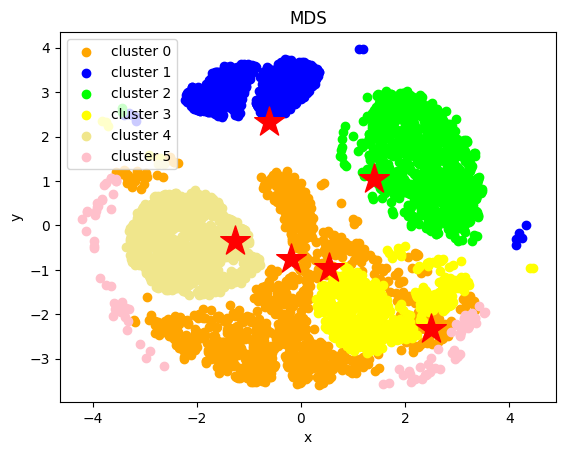

In [45]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

## Applying t-SNE to project the data and clusters to a 2D space

In [47]:
XYcoordinates = manifold.TSNE(n_components=2,).fit_transform(data_and_centers)

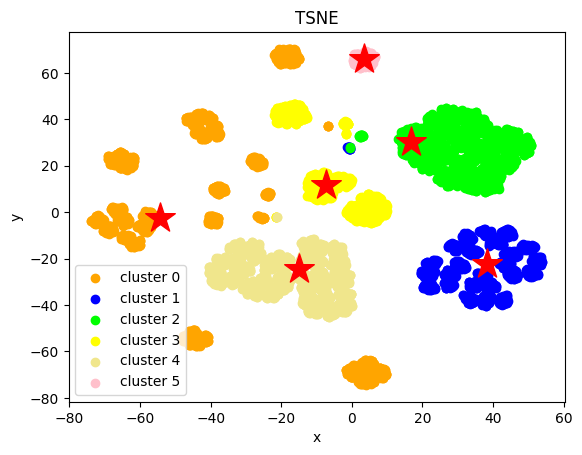

In [48]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### Adding the cluster labels to the original dataframe 

In [49]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

#### mean value for each attribute for each cluster

In [51]:
pd.set_option('display.max_columns', None)
df_cluster = df.groupby('cluster').mean()

In [55]:
df_cluster.head()

,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,class_poisonous,gill-attachment_free,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,gill-size_narrow,gill-spacing_crowded,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,population_clustered,population_numerous,population_scattered,population_several,population_solitary,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,stalk-color-above-ring_buff,stalk-color-above-ring_cinammon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_buff,stalk-color-below-ring_cinammon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,stalk-root_club_1,stalk-root_equal_1,stalk-root_nan_1,stalk-root_rooted_1,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.156902,0.828203,0.087388,0.002979,0.124131,0.00993,0.082423,0.006951,0.023833,0.319762,0.169811,0.000000,0.494538,0.313803,0.029791,0.019861,0.001986,0.390268,0.481629,0.439921,1.00000,0.167825,0.000000,0.057597,0.110228,0.015889,0.0,0.171797,0.032771,0.053625,0.281033,0.000000,0.357498,0.101291,0.003972,0.146971,0.058590,0.195631,0.097319,0.162860,0.188679,0.099305,0.000000,0.151936,0.000000,0.232373,0.141013,0.00000,0.101291,0.124131,0.354518,0.331678,0.088381,0.021847,0.000000,0.000000,0.880834,0.328699,0.0,0.173784,0.043694,0.0,0.023833,0.117180,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.046673,0.952334,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.051639,0.947368,0.000000,0.243297,0.190665,0.119166,0.090367,0.193644,0.000993,0.000000,0.925521,0.091360,0.000000,0.817279,0.0,1.00000,0.00000
1,0.978884,0.000000,0.000000,0.003017,0.506787,0.00000,0.000000,0.000000,0.007541,0.000000,0.472097,0.000000,0.496229,0.499246,0.004525,0.000000,0.000000,0.521870,0.000000,1.000000,0.99095,0.000000,0.000000,0.310709,0.334842,0.000000,0.0,0.333333,0.000000,0.000000,0.010558,0.010558,0.000000,0.000000,0.000000,0.000000,0.355958,0.000000,0.000000,0.340875,0.000000,0.000000,0.000000,0.978884,0.021116,0.000000,0.000000,0.00000,0.021116,0.000000,0.000000,0.487179,0.491704,0.000000,0.978884,0.021116,0.000000,0.000000,0.0,0.978884,0.000000,0.0,0.000000,0.021116,0.0,0.330317,0.021116,0.000000,0.0,0.307692,0.000000,0.000000,0.00000,0.312217,0.021116,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.021116,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.021116,0.978884,0.000000,0.0,1.00000,0.00000
2,0.997750,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.469066,0.000000,0.007874,0.000000,0.320585,0.340832,0.332958,0.000000,0.000000,0.508436,0.480315,1.000000,0.99775,0.000000,0.978628,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.020247,0.001125,0.997750,0.000000,0.314961,0.000000,0.320585,0.000000,0.000000